# Table of Contents
* [Set up environment](#env)
* [Read in Data](#load)
    * [Map IP Address to Country](#ip)
    * [Feature Engineering](#fea)
    * [Variable Sanity Check](#san)
* [Fraudulent Activity Prediction](#pres)
    * [Grid Search Hyper-parameters](#hyper)
    * [Optimal Random Forest Model](#opt) 
    * [Implications of False Positives vs False Negatives](#fp)
    * [Images of High Fraudulent Risk Users](#im)   
* [Model Usage and Recommendation](#re)

* E-commerce website pages:
home page -> (search) -> search page -> (click on a product) -> payment page -> (fill in payment information) -> confirmation page (confirm to buy)

The tables record the user first experience on the site.

* Goal of the challenge:
Check abnormal behavior in the data;

A full picture of funnel conversion rate for both desktop and mobile;

What the product team should focus on in order to improve conversion rate as well as anything you might discover that could help improve conversion rate.

# Set up Environment
<a id="env"></a> 

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import warnings
warnings.simplefilter('default')
from scipy import stats

# Read in Data
<a id="load"></a> 

In [2]:
user_df = pd.read_csv("./Funnel/user_table.csv", sep = ',')

In [3]:
home_df = pd.read_csv("./Funnel/home_page_table.csv", sep = ',')

In [4]:
search_df = pd.read_csv("./Funnel/search_page_table.csv", sep = ',')

In [5]:
pay_df = pd.read_csv("./Funnel/payment_page_table.csv", sep = ',')

In [6]:
confirm_df= pd.read_csv("./Funnel/payment_confirmation_table.csv", sep = ',')

## Sanity Check
<a id="san"></a> 

There is no duplicates and null values in all five data tables.

In [7]:
user_df.duplicated(subset=None, keep='first').sum()

0

In [8]:
user_df.user_id.duplicated().sum()

0

In [9]:
user_df.isnull().sum()

user_id    0
date       0
device     0
sex        0
dtype: int64

In [10]:
home_df.duplicated(subset = None, keep = 'first').sum()

0

In [11]:
home_df.user_id.duplicated().sum()

0

In [12]:
home_df.isnull().sum()

user_id    0
page       0
dtype: int64

In [13]:
search_df.duplicated(subset = None, keep = 'first').sum()

0

In [14]:
search_df.user_id.duplicated().sum()

0

In [15]:
search_df.isnull().sum()

user_id    0
page       0
dtype: int64

In [16]:
pay_df.duplicated(subset = None, keep = 'first').sum()

0

In [17]:
pay_df.user_id.duplicated().sum()

0

In [18]:
pay_df.isnull().sum()

user_id    0
page       0
dtype: int64

In [19]:
confirm_df.duplicated(subset = None, keep = 'first').sum()

0

In [20]:
confirm_df.user_id.duplicated().sum()

0

In [21]:
confirm_df.isnull().sum()

user_id    0
page       0
dtype: int64

## Univariate Analysis
<a id="uni"></a> 

In [22]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
user_id    90400 non-null int64
date       90400 non-null object
device     90400 non-null object
sex        90400 non-null object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [23]:
user_df['date'] = pd.to_datetime(user_df.date)

In [24]:
user_df.device.value_counts()

Desktop    60200
Mobile     30200
Name: device, dtype: int64

In [25]:
user_df.sex.value_counts()

Male      45325
Female    45075
Name: sex, dtype: int64

## Feature Engineering
<a id="fe"></a> 

In [26]:
user_df['week'] = user_df['date'].dt.week
user_df['weekday'] = user_df['date'].dt.weekday_name

# Conversion Rate
<a id="conv"></a> 

In [27]:
home_df = home_df.merge(user_df, on = 'user_id', how = 'left')

In [28]:
search_df = search_df.merge(user_df, on = 'user_id', how = 'left')

In [29]:
pay_df = pay_df.merge(user_df, on='user_id', how = 'left')

In [30]:
confirm_df = pay_df.merge(confirm_df, on='user_id', how = 'left')

## Desktop Conversion Rate
<a id="desk"></a> 

In [31]:
home_df_desk = home_df[home_df.device == 'Desktop']
search_df_desk = search_df[search_df.device == 'Desktop']
pay_df_desk = pay_df[pay_df.device == 'Desktop']
confirm_df_desk = confirm_df[confirm_df.device == 'Desktop']

In [32]:
## conversion rate: homepage -> search page
desktop_search_conv_rate = round(1.0 * search_df_desk.user_id.nunique()/home_df_desk.user_id.nunique(), 3)
desktop_pay_conv_rate = round(1.0 * pay_df_desk.user_id.nunique()/search_df_desk.user_id.nunique(), 3)
desktop_order_conv_rate = round(1.0 * confirm_df_desk.user_id.nunique()/pay_df_desk.user_id.nunique(), 3)
print('desktop_search_conv_rate: ''{0:0.2f}'.format(desktop_search_conv_rate), 
      'desktop_pay_conv_rate: ''{0:0.2f}'.format(desktop_pay_conv_rate),
      'desktop_order_conv_rate: ''{0:0.2f}'.format(desktop_order_conv_rate))

('desktop_search_conv_rate: 0.50', 'desktop_pay_conv_rate: 0.10', 'desktop_order_conv_rate: 1.00')


## Mobile Conversion Rate
<a id="mob"></a> 

In [33]:
home_df_mob = home_df[home_df.device == 'Mobile']
search_df_mob = search_df[search_df.device == 'Mobile']
pay_df_mob = pay_df[pay_df.device == 'Mobile']
confirm_df_mob = confirm_df[confirm_df.device == 'Mobile']

In [34]:
## conversion rate: homepage -> search page
mobile_search_conv_rate = round(1.0 * search_df_mob.user_id.nunique()/home_df_mob.user_id.nunique(), 3)
mobile_pay_conv_rate = round(1.0 * pay_df_mob.user_id.nunique()/search_df_mob.user_id.nunique(), 3)
mobile_order_conv_rate = round(1.0 * confirm_df_mob.user_id.nunique()/pay_df_mob.user_id.nunique(), 3)
print('mobile_search_conv_rate: ''{0:0.2f}'.format(mobile_search_conv_rate), 
      'mobile_pay_conv_rate: ''{0:0.2f}'.format(mobile_pay_conv_rate),
      'mobile_order_conv_rate: ''{0:0.2f}'.format(mobile_order_conv_rate))

('mobile_search_conv_rate: 0.50', 'mobile_pay_conv_rate: 0.20', 'mobile_order_conv_rate: 1.00')


In [60]:
def count_plot(data, x_axis, group, plot_name):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 5))
    sns.countplot(x = x_axis, hue = group, data = data, ax = ax)
    ax.set_title(plot_name + 'Count Plot of ' + x_axis, fontsize = 16)
    #ax.set_yscale('log')
    plt.tight_layout()
    plt.show() 
    return None

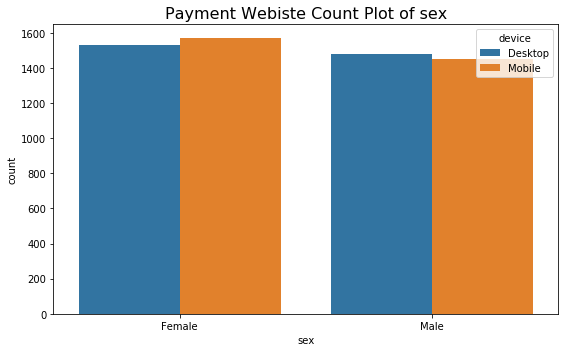

In [61]:
count_plot(pay_df, 'sex', 'device', 'Payment Webiste ')

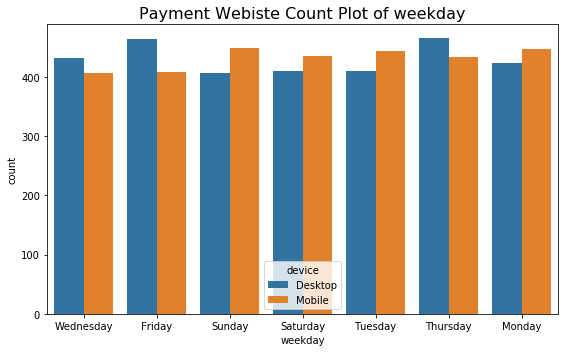

In [62]:
count_plot(pay_df, 'weekday', 'device', 'Payment Webiste ')

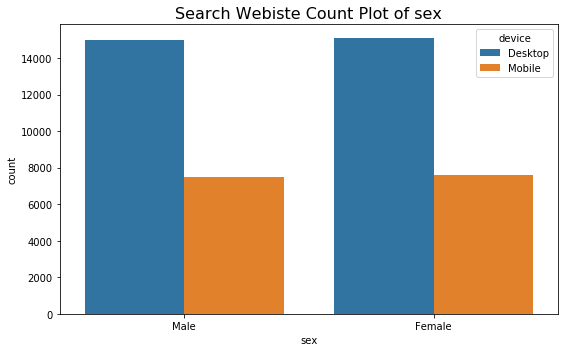

In [63]:
count_plot(search_df, 'sex', 'device', 'Search Webiste ')

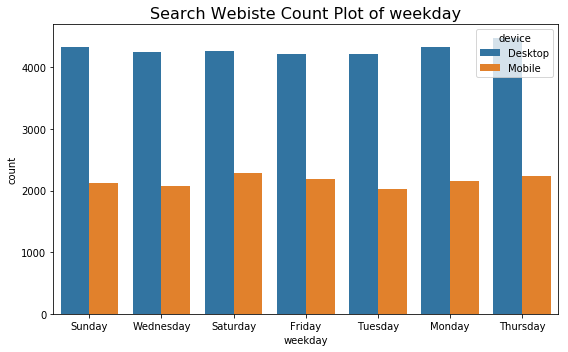

In [64]:
count_plot(search_df, 'weekday', 'device', 'Search Webiste ')

The conversion rate from search result to click on the product is only 0.10 on the desktop platform, which is half than the mobile platform. The product team should trouble shoot on the search result page. Is that because the payout of the search results on the desktop platform is imappropriately displayed on the desktop screen? We may need web browser types, ip address(country) information to discover the reason of low conversion rate on the desktop platform from search result page to payment page.